In [1]:
from scipy import stats
import pandas as pd
import numpy as np
import os
import seaborn as sns   # Why sns?  It's a reference to The West Wing
import matplotlib.pyplot as plt  # seaborn is based on matplotlib
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
sns.set(color_codes=True) # adds a nice background to the graphs
%matplotlib inline

In [3]:
def load_dataframe_from_csv(csv_file_name:str)->pd.DataFrame: 
    """Load a csv file and return a pandas dataframe.

    Parameters
    ----------
    csv_file_name : str
        The csv file

    Return
    ----------
    data_frame : DataFrame
        Pandas data frame

    Raises
    ------
    AssertionError
        If the file type is not of type csv
    """

    file_name = str(csv_file_name)
    _,file_type=os.path.splitext(file_name)
    assert file_type == '.csv',f"File format should be of type csv instead of format {file_type}"

    data_frame = pd.read_csv(csv_file_name)
    return data_frame

def print_frame_meta_info(data_frame:pd.DataFrame): 
    """Load a data frame file and print meta info of the data frame.

    Parameters
    ----------
    data_frame : DataFrame
    """
    rows,columns = np.shape(data_frame)
    print(f"Shape of the data frame is: {rows},{columns}")
    print(f"Number of variables are: {columns}")
    print("Memory Usage:"+str(data_frame.memory_usage(index=False,deep=True).sum()*0.001))
    print("")
    print("")
    
    categorical = 0
    numerical = 0

    
    for column in data_frame.columns:
        print(f"Name of the column: {column}")
            
        data_in_column = data_frame[column]
            
        metadata_column = [element for element in data_in_column.notna()]
        number_missing = metadata_column.count(False)
        
        print("Number of missing values:"+str(number_missing))
        percent_missing = ((number_missing)/len(data_in_column))*100.0
        print("% of missing values:"+str(percent_missing))
        print("Memory Usage:"+str(data_in_column.memory_usage()*0.001))
        print("")
    

In [4]:
# load the dataset
raw_data = load_dataframe_from_csv("used_cars_data.csv")
# create a copy, where we can work with for the analysis
data = raw_data.copy(deep=True)

# Meta info about the dataframe

In [5]:
print_frame_meta_info(data)

Shape of the data frame is: 7253,14
Number of variables are: 14
Memory Usage:4406.794


Name of the column: S.No.
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Name
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Location
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Year
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Kilometers_Driven
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Fuel_Type
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Transmission
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Owner_Type
Number of missing values:0
% of missing values:0.0
Memory Usage:58.152

Name of the column: Mileage
Number of missing values:2
% of missing values:0.02757479663587481
Memo

In [6]:
# serial number indexing is exactly same as the pandas and also not needed for the analysis, hence dropping it.
data.drop(['S.No.'],axis=1,inplace=True)

# # New price column has 86 % missing data and it needs to be dropped (since filling with mean or median will only 
# # corrupt the analysis)
# data.drop(['New_Price'],axis=1,inplace=True)


In [7]:
data.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


# Univariate analysis of all variables

Univariate Analysis of Brand


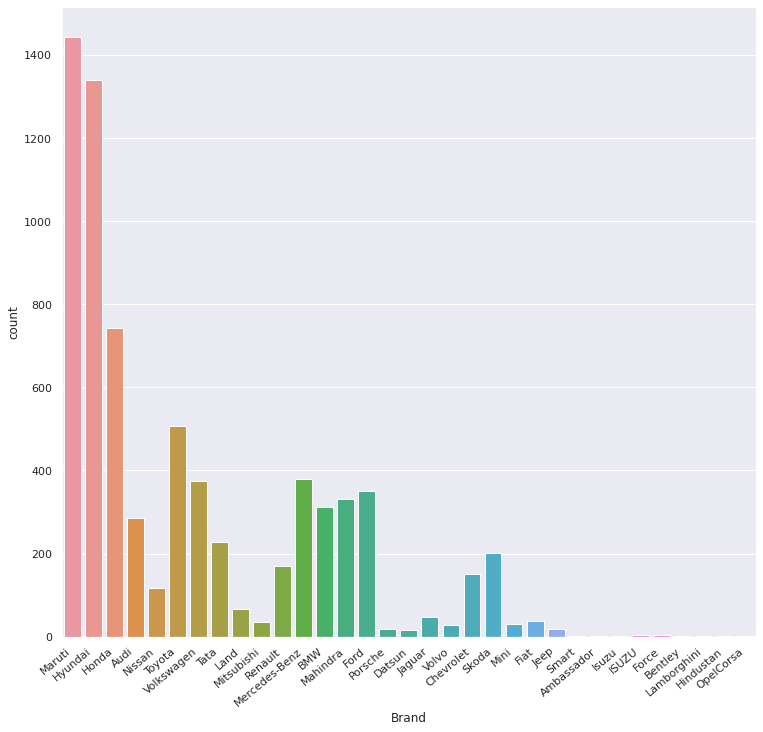

Number of used cars of make Ambassador: 1
Number of used cars of make Audi: 285
Number of used cars of make BMW: 312
Number of used cars of make Bentley: 2
Number of used cars of make Chevrolet: 151
Number of used cars of make Datsun: 17
Number of used cars of make Fiat: 38
Number of used cars of make Force: 3
Number of used cars of make Ford: 351
Number of used cars of make Hindustan: 1
Number of used cars of make Honda: 743
Number of used cars of make Hyundai: 1340
Number of used cars of make ISUZU: 3
Number of used cars of make Isuzu: 2
Number of used cars of make Jaguar: 48
Number of used cars of make Jeep: 19
Number of used cars of make Lamborghini: 1
Number of used cars of make Land: 67
Number of used cars of make Mahindra: 331
Number of used cars of make Maruti: 1444
Number of used cars of make Mercedes-Benz: 380
Number of used cars of make Mini: 31
Number of used cars of make Mitsubishi: 36
Number of used cars of make Nissan: 117
Number of used cars of make OpelCorsa: 1
Number 

In [8]:
def get_brand_names():
    """This function takes in a used car name and repopulates the name column with
    the Brand name. we will strip out everything except the make name of the car.
    This helps in better visualization and better analysis of the data as seen in the plot
    below.
    """
    
    brand_names = []
    for name in data.Name:
        name_split=name.split()
        # Just using the brand name as it yields better comparison than considering model name, trim etc
        brand_name = name_split[0]
        brand_names.append(brand_name)
    return brand_names

print("Univariate Analysis of Brand")
# There are two many different types of car names in the dataset, but there are limited number
# of brands. So we are making a new column called brand and analyse that (which is friendly for analysis 
# and discussion.
# Also as seen below, Maruthi is most used card brand.
data['Brand'] = get_brand_names()
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 10.27)
ax = sns.countplot(x="Brand", data=data)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

for brand in np.unique(data.Brand):
    print(f"Number of used cars of make {brand}: {len(data[(data.Brand == brand)])}")

Univariate Analysis of Location
Number of used cars in Ahmedabad: 275
Number of used cars in Bangalore: 440
Number of used cars in Chennai: 591
Number of used cars in Coimbatore: 772
Number of used cars in Delhi: 660
Number of used cars in Hyderabad: 876
Number of used cars in Jaipur: 499
Number of used cars in Kochi: 772
Number of used cars in Kolkata: 654
Number of used cars in Mumbai: 949
Number of used cars in Pune: 765


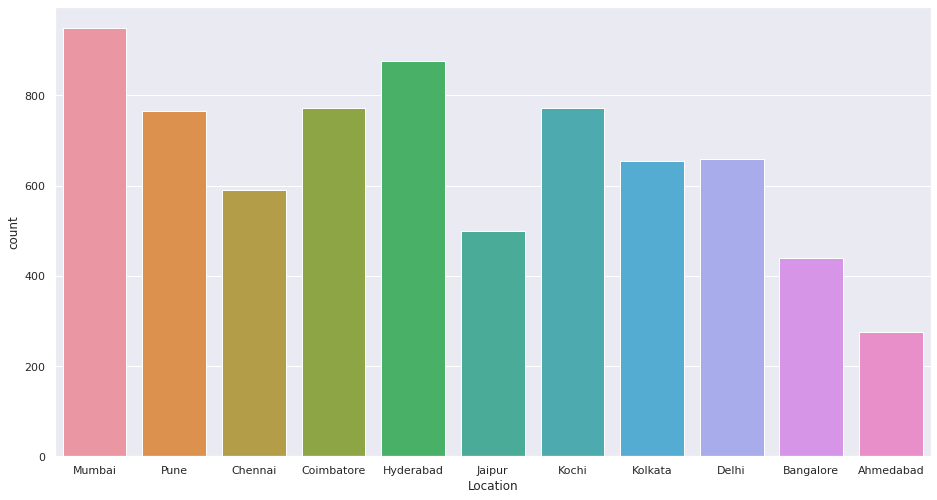

In [7]:
print("Univariate Analysis of Location")
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 8.27)
sns.countplot(x=data.Location);
for Location in np.unique(data.Location):
    print(f"Number of used cars in {Location}: {len(data[(data.Location == Location)])}")

Univariate Analysis of car make Year
Max make year is 2019
Min make year is 1996
Mean make year is 2013.3653660554253


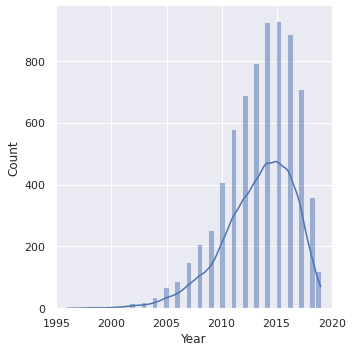

In [8]:
print("Univariate Analysis of car make Year")
sns.displot(data.Year,kde=True);
print(f"Max make year is {np.max(data.Year)}")
print(f"Min make year is {np.min(data.Year)}")
print(f"Mean make year is {np.mean(data.Year)}")

Univariate Analysis of km driven
Max km driven is 6500000
Min km driven is 171
Mean km driven is 58699.063146284294


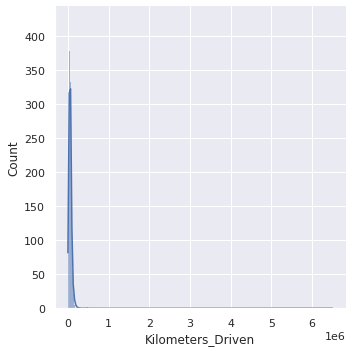

In [9]:
print("Univariate Analysis of km driven")
sns.displot(data.Kilometers_Driven,kde=True);
print(f"Max km driven is {np.max(data.Kilometers_Driven)}")
print(f"Min km driven is {np.min(data.Kilometers_Driven)}")
print(f"Mean km driven is {np.mean(data.Kilometers_Driven)}")

Univariate Analysis of Location
Number of fuel type CNG: 62
Number of fuel type Diesel: 3852
Number of fuel type Electric: 2
Number of fuel type LPG: 12
Number of fuel type Petrol: 3325


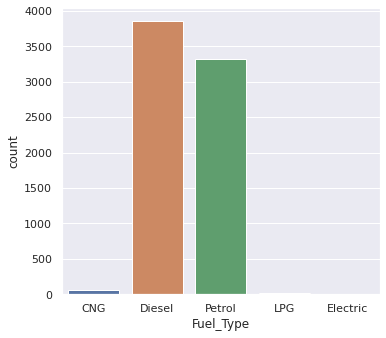

In [10]:
print("Univariate Analysis of Location")
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 5.27)
sns.countplot(x=data.Fuel_Type);
for fuel_type in np.unique(data.Fuel_Type):
    print(f"Number of fuel type {fuel_type}: {len(data[(data.Fuel_Type == fuel_type)])}")

Univariate Analysis of Transmission
Number of transmission type Automatic: 2049
Number of transmission type Manual: 5204


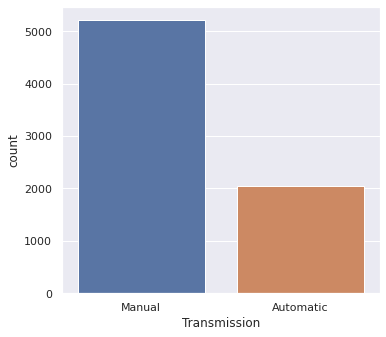

In [11]:
print("Univariate Analysis of Transmission")
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 5.27)
sns.countplot(x=data.Transmission);
for transmission in np.unique(data.Transmission):
    print(f"Number of transmission type {transmission}: {len(data[(data.Transmission == transmission)])}")

Univariate Analysis of Owner type
Number of owner type First: 5952
Number of owner type Fourth & Above: 12
Number of owner type Second: 1152
Number of owner type Third: 137


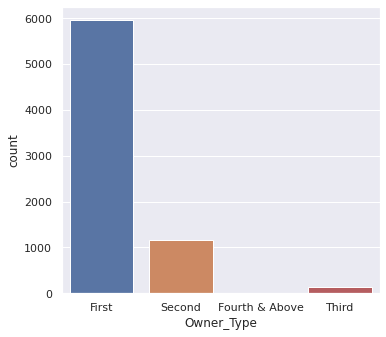

In [12]:
print("Univariate Analysis of Owner type")
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 5.27)
sns.countplot(x=data.Owner_Type);
for owner_type in np.unique(data.Owner_Type):
    print(f"Number of owner type {owner_type}: {len(data[(data.Owner_Type == owner_type)])}")

Univariate Analysis of Seats
Max number of seats are 10.0
Min number of seats are 2.0
Mean number of seats are 5.278367572039156


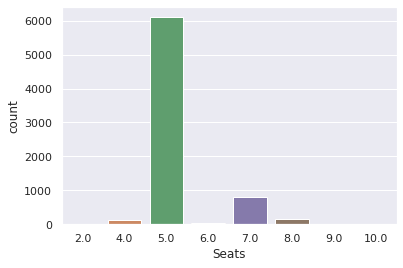

In [13]:
print("Univariate Analysis of Seats")
# Seats has about 0.73 % missing values (as per the meta analysis above)
# we will replace the nan seats with the mode value
seats_mode = data['Seats'].mode()[0]
data['Seats'].fillna(seats_mode, inplace=True)

# Treating outlier with 0 seats:
#Also one of the entries has 0 seats, which might have been a user entry error. 
# So replace all cars with 0 seats with the mode too
for entry_with_0_seat in data.index[data['Seats'] == 0].tolist():
    data.iloc[entry_with_0_seat, data.columns.get_loc('Seats')] = seats_mode
    

sns.countplot(x=data.Seats);
print(f"Max number of seats are {np.max(data.Seats)}")
print(f"Min number of seats are {np.min(data.Seats)}")
print(f"Mean number of seats are {np.mean(data.Seats)}")

Univariate Analysis of car mileage
Max make mileage is 33.54
Min make mileage is 0.0
Mean make mileage is 18.141580471659108


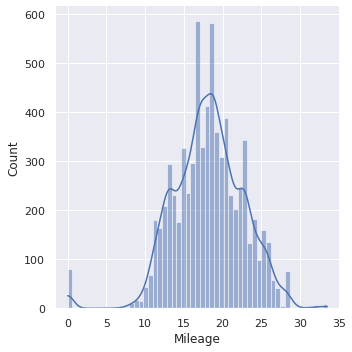

In [14]:
def get_mileages():
    """This function takes in a mileage and strips of the string and
    just returns float mileage (which is usable)
    """
    mileages = []
    for mileage in data.Mileage:
        
        if mileage is not np.nan:
            mileages.append(float(mileage.split()[0]))
        else:
            mileages.append(np.nan)
    return mileages

data.Mileage = get_mileages()
mileage_mean = data['Mileage'].mean()
# Fill the missing mileage with the mean value.
data['Mileage'].fillna(mileage_mean, inplace=True)

print("Univariate Analysis of car mileage")
sns.displot(data.Mileage,kde=True);
print(f"Max make mileage is {np.max(data.Mileage)}")
print(f"Min make mileage is {np.min(data.Mileage)}")
print(f"Mean make mileage is {np.mean(data.Mileage)}")

Univariate Analysis of car engine
Max Engine cc is 5998.0
Min Engine cc is 72.0
Mean Engine cc is 1616.5734702372695


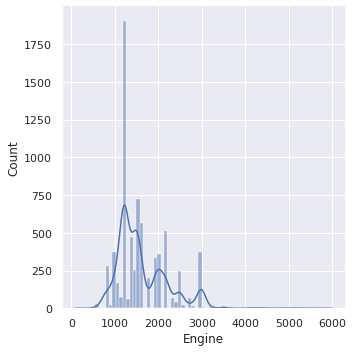

In [15]:
def get_engines():
    """This function takes in a engine element and strips of the string and
    just returns float engine (which is usable)
    """
    engines = []
    for engine in data.Engine:
        
        if engine is not np.nan:
            engines.append(float(engine.split()[0]))
        else:
            engines.append(np.nan)
    return engines

data.Engine = get_engines()
# fill the missing engine with mean value
engine_mean = data['Engine'].mean()
data['Engine'].fillna(engine_mean, inplace=True)

print("Univariate Analysis of car engine")
sns.displot(data.Engine,kde=True);
print(f"Max Engine cc is {np.max(data.Engine)}")
print(f"Min Engine cc is {np.min(data.Engine)}")
print(f"Mean Engine cc is {np.mean(data.Engine)}")

Univariate Analysis of Power
Max Horse power is 616.0
Min Horse power is 34.2
Mean Horse power is 112.76521404351442


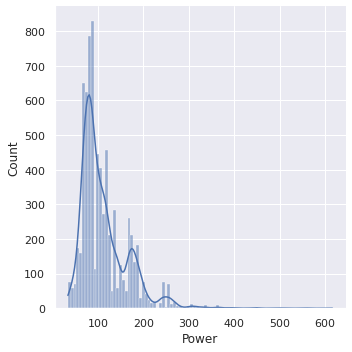

In [16]:
def get_hps():
    """This function takes in a power element and strips of the string and
    just returns float horse power (which is usable).
    """
    hps= []
    for hp in data.Power:
        if hp is not np.nan:
            hp_ = hp.split()[0]
            if hp_ == 'null':
                hps.append(np.nan)
            else:
                hps.append(float(hp_))
        else:
            hps.append(np.nan)
    return hps

data.Power = get_hps()
hps_mean = data['Power'].mean()
# fill the missing horse power with the mean value
data['Power'].fillna(hps_mean, inplace=True)

print("Univariate Analysis of Power")
sns.displot(data.Power,kde=True);
print(f"Max Horse power is {np.max(data.Power)}")
print(f"Min Horse power is {np.min(data.Power)}")
print(f"Mean Horse power is {np.mean(data.Power)}")

Univariate Analysis of Price
Max Price is 160.0
Min Price is 0.44
Mean Price is 9.479468350224558


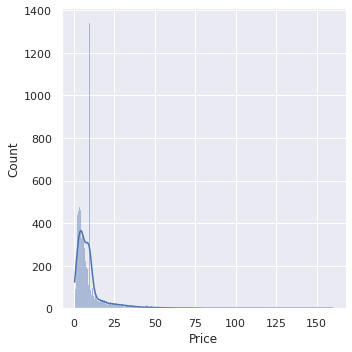

In [17]:
price_mean = data['Price'].mean()
# fill the missing price with mean value
data['Price'].fillna(price_mean, inplace=True)

print("Univariate Analysis of Price")

sns.displot(data.Price,kde=True);
print(f"Max Price is {np.max(data.Price)}")
print(f"Min Price is {np.min(data.Price)}")
print(f"Mean Price is {np.mean(data.Price)}")

# BI-VARIATE ANALYSIS

## Some observations from the heatmap

- As expected there is a slight positive correlation between the year and the mileage (0.32)
- Negative correlation seen Mileage and power , Mileage and Engine (Mostly higher hp and high cc vehicles has less
  mileage.
- Negative correlation between mileage and seats (basically two seaters has lesser milleage, so this makes sense)
- Negative between mileage and price. (Makese sense, family friendly sedans and minivans are cheaper than sports vehicles, which has lesser mileage mostly)
- As expected strong positive correlation between Engine and power (better the enginer, the more horse power)
- Positive correlation between engine and price (better enginers more price)
- Good positive correlation between horse power and price (more power more price)

<AxesSubplot:>

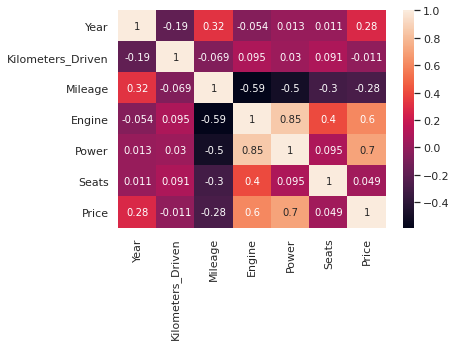

In [18]:
sns.heatmap(data.corr(), annot=True)  # plot the correlation coefficients 

## Studying Mileage, Brand and Transmission

### Some observations from the plot below:

- Maruthi automatic, Tata automatic, Renault manual and Datsun manual seems to give the best mileage
- Automatic vehicle with the worst mileage is Lamborghini (ok, now I dont want to buy one :) ) 
- Manual vehicle with the worst mileage is Porsche.

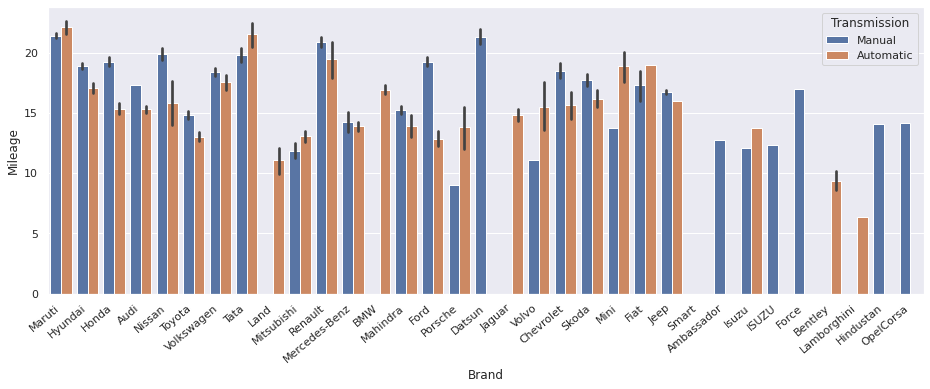

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(15.7, 5.27)
ax = sns.barplot(x=data['Brand'], y=data['Mileage'],hue=data['Transmission']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");


## Studying Mileage, Brand and Fuel type

### Some observations from the plot below:

- For fuel type, CNG: Maruthi has the highest mileage.
- For fuel type, Diesel: Honda has the highest mileage.
- For fuel type, Petrol: Renault has the highest mileage.
- For fuel type, Electric: Toyota and Mahindr has the highest mileage.

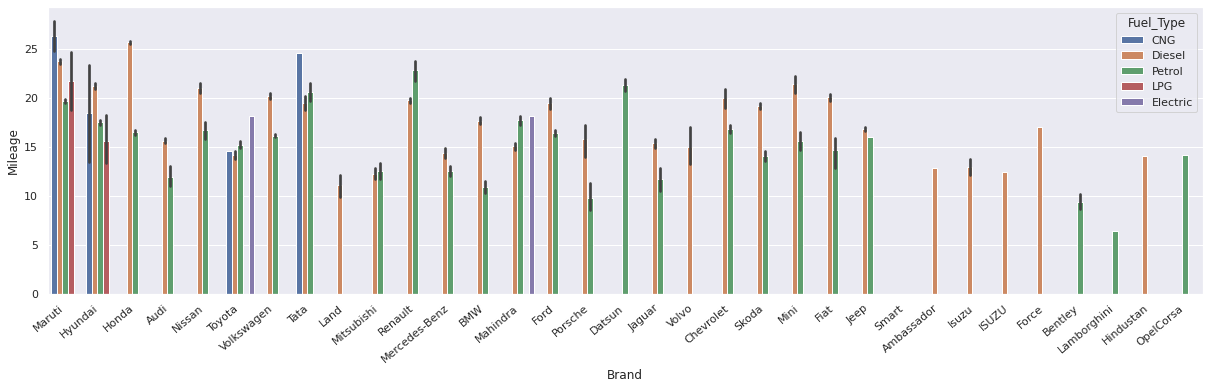

In [20]:
fig, ax = plt.subplots()
fig.set_size_inches(20.7, 5.27)
ax = sns.barplot(x=data['Brand'], y=data['Mileage'],hue=data['Fuel_Type']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

## Studying Brand and Kilometer driven

### Some observations from the plot below:

- ISUZU has the highest Kilometers driven.
- Smart has the second highest kilometers driven.
- Lamborghini has the lowest kilometers driven.

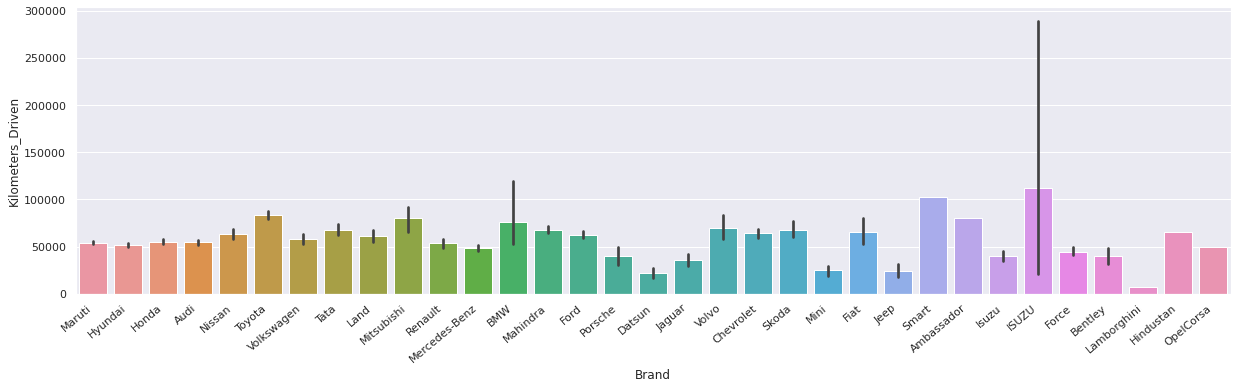

In [21]:
fig, ax = plt.subplots()
fig.set_size_inches(20.7, 5.27)
ax = sns.barplot(x=data['Brand'], y=data['Kilometers_Driven']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

## Studying Kilometer driven and Fuel type

### Some observations from the plot below:

- Diesel vehicles have the highest kilometer driven.
- LPG vehicles have the second highest kilometer driven.
- CNG vehicles have the third highest kilometer driven.
- Electric vehicles have the least kilometers driven.

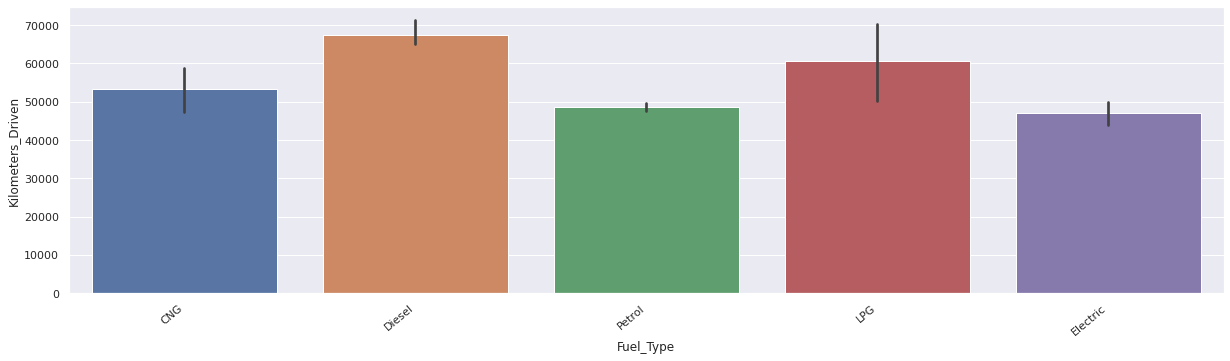

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(20.7, 5.27)
ax = sns.barplot(x=data['Fuel_Type'], y=data['Kilometers_Driven']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

## Studying Location and Fuel type

### Some observations from the plot below:

- Mumbai has the highest count of vehicles with fuel type Petrol
- Hyderabad has the highest count of vehicles with fuel type Diesel
- Mumbai has the highest count of vehicles with fuel type CNG
- Hyderabad has the highest count of vehicles with fuel type LPG

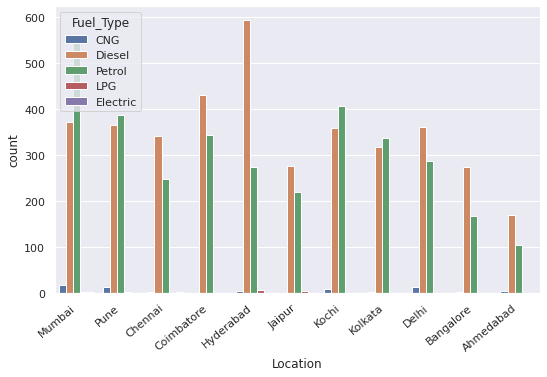

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(8.7, 5.27)
ax = sns.countplot(x=data['Location'], hue=data['Fuel_Type']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

## Studying Price and Brand

### Some observations from the plot below:

- Apparently, Lamborghini is the most expensive car.
- Ambassador is the cheapest car.
- Bentley is the second most expensive car.
- Porsche is the third most expensive car.


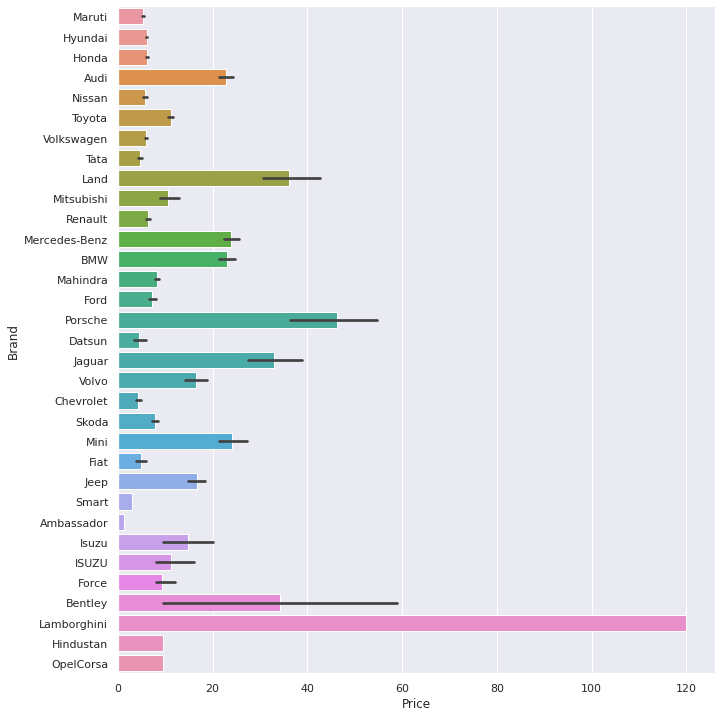

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 12.27)
ax = sns.barplot(x=data['Price'], y=data['Brand']);

## Studying Price and Location

### Some observations from the plot below:

- Coimbator has the most high price cars.
- Bangalor has the second most high price cars.
- Kolkata has the least expensive cars.
- Jaipur has the second least expensive cars.


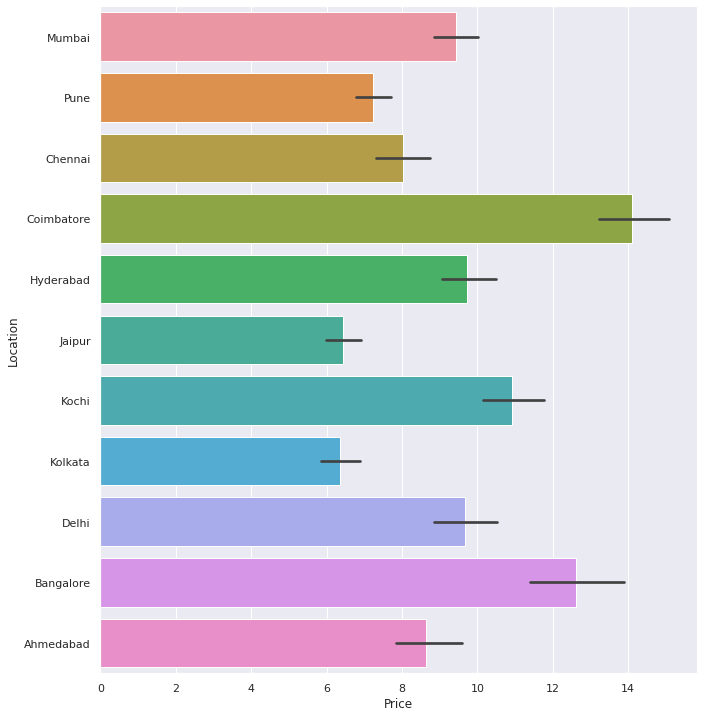

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 12.27)
ax = sns.barplot(x=data['Price'], y=data['Location']);

## Studying Seats and Brand

### Some observations from the plot below:

- Mahindra, Isuzu, Force are the only brands with 7 seaters.
- Majority of brands support 5 seaters.


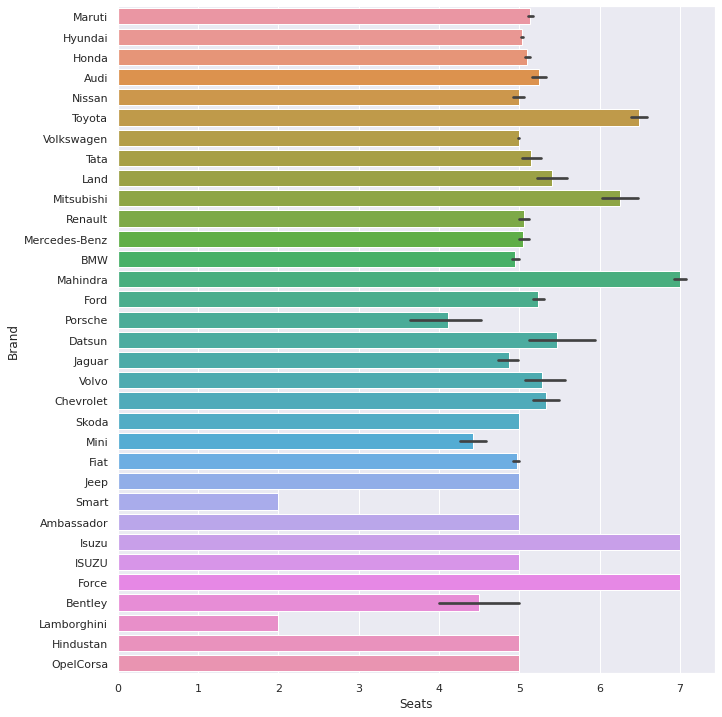

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10.7, 12.27)
ax = sns.barplot(x=data['Seats'], y=data['Brand']);

## Studying Seats and Price

### Some observations from the plot below:

- Most of the 2 seaters are luxury vehicles (like porsche and lamborghini) and being the most expensive.
- 9 and 10 seaters are the least expensive vehicles.
- 4 seaters are the second expensive cars.

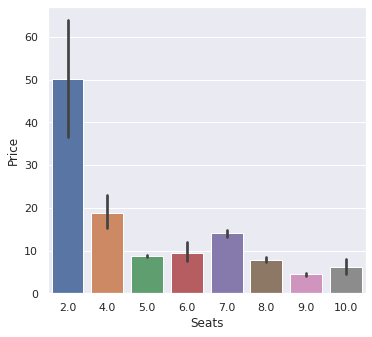

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 5.27)
ax = sns.barplot(x=data['Seats'], y=data['Price']);

## Studying Owner type and Price

### Some observations from the plot below:

- First owner type vehicles are most expensive.
- Fourth and above are the least expensive.

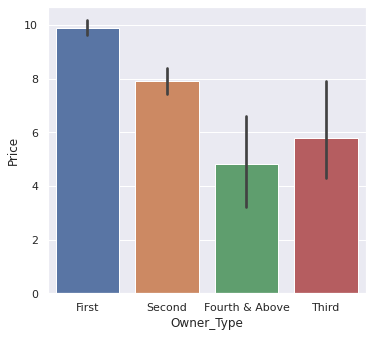

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(5.7, 5.27)
ax = sns.barplot(x=data['Owner_Type'], y=data['Price']);

## Studying Owner type and Location

### Some observations from the plot below:

- Mumbai and Hyderabad has the most first owner type vehicles.
- Pune has the most second owner type vehicles.
- Chennia and Pune has the most third owner type vehicles.

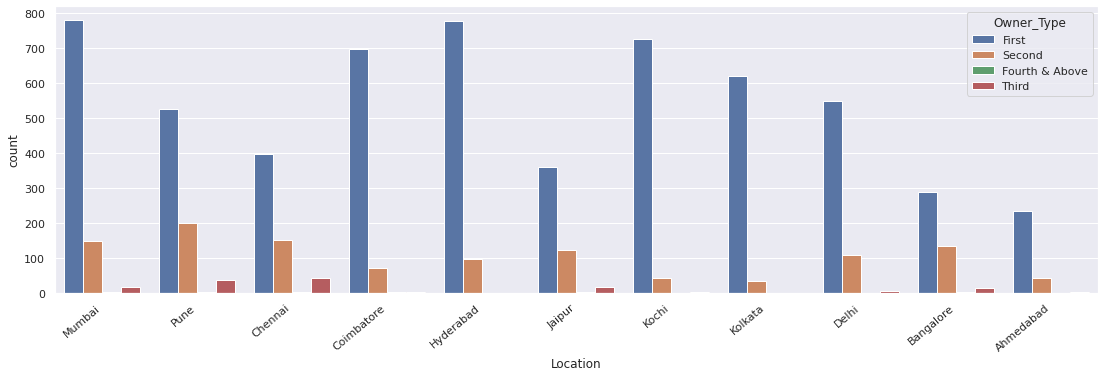

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(18.7, 5.27)
ax = sns.countplot(x=data['Location'], hue=data['Owner_Type']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

## Studying Owner type and Location

### Some observations from the plot below:

- Lamborghini is the most expensive auotmatic car
- Smart is the least expensive automatic car
- Land brand is the most expensive Manual type car.
- Ambassador is the least expensive manual type car.

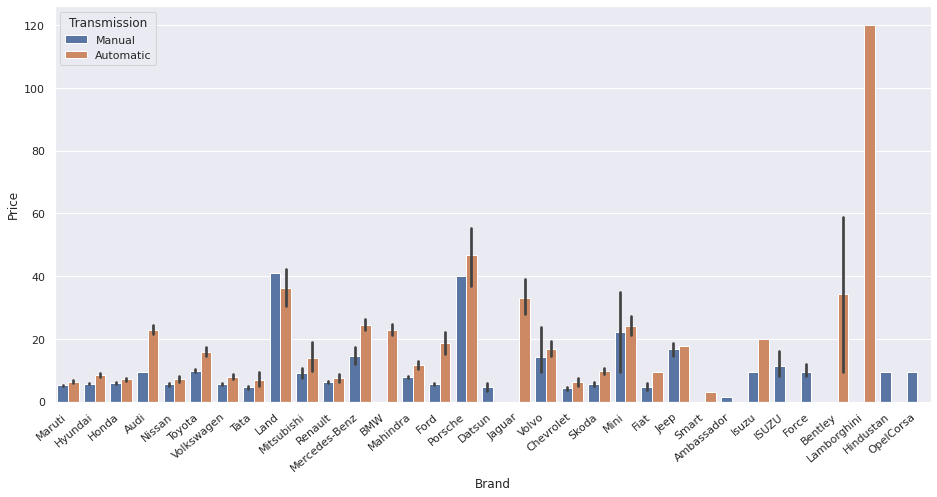

In [30]:
fig, ax = plt.subplots() 
fig.set_size_inches(15.7, 7.27)
ax = sns.barplot(x=data['Brand'], y=data['Price'],hue=data['Transmission']);
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

# Feature engineering

## Apply logarithmic transformation to the data

- As you can see in the plots below, the power, price and km are skewed.
- Year, Seats (which does not make sense to apply transformation) seems to be well distributed (atleast Year is normally distributed)


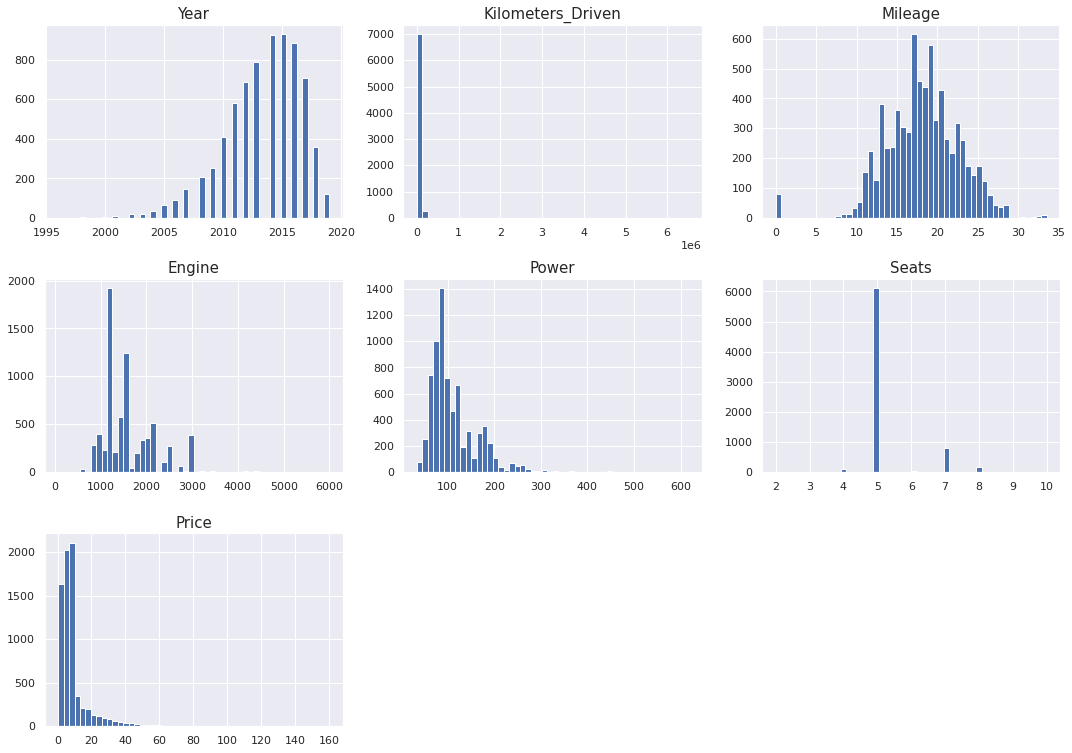

In [31]:

# creating a list of numerical columns
num_cols = [
    num_col for num_col in data.select_dtypes(include=np.number).columns
]

plt.figure(figsize=(15, 35))

# then plot the numerical columns.
for i in range(len(num_cols)):
    plt.subplot(10, 3, i + 1)
    plt.hist(data[num_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=15)

plt.show()

In [32]:
# creating a copy of the dataframe, this copy will be specifically used for building the regression model
data_for_model_building = data.copy()

# these two are less skewed and no need to apply log on it.and it might also corrupt the column
num_cols.remove("Year")
num_cols.remove("Seats")

# using log transforms on some columns
for col in num_cols:
    data_for_model_building[col + "_log"] = np.log(data_for_model_building[col] + 1)


# drop the original numerical columns and use the log ones.
data_for_model_building.drop(num_cols, axis=1, inplace=True)


## Examining the plot after log transforms

- The mileage, enginer, power, km drive, price log are definitely less skewed now.


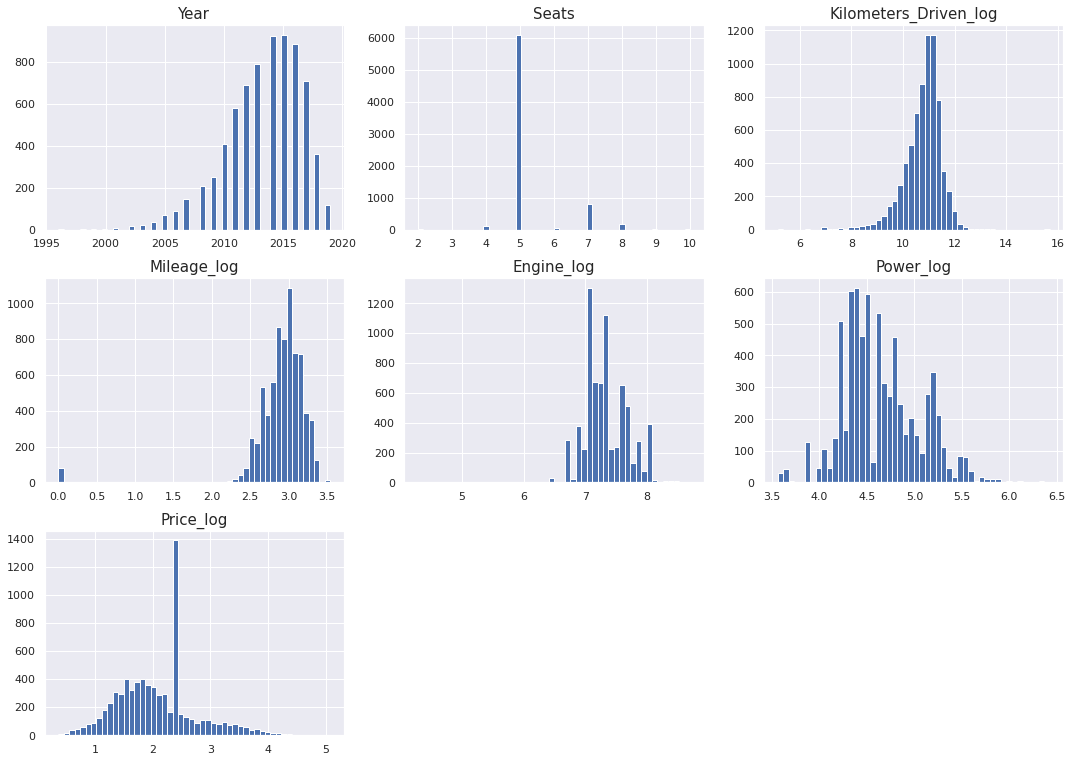

In [33]:

# creating a list of numerical columns with log transform applied.
num_cols = [
    num_col for num_col in data_for_model_building.select_dtypes(include=np.number).columns
]

plt.figure(figsize=(15, 35))

for i in range(len(num_cols)):
    plt.subplot(10, 3, i + 1)
    plt.hist(data_for_model_building[num_cols[i]], bins=50)
    plt.tight_layout()
    plt.title(num_cols[i], fontsize=15)

plt.show()

# Model Building

*Some key decisions*
- we are dropping the name column, since there are too many. and considering name, yields poor performance
- instead of name, brand names are used, which yields better models and also friendly for analysis etc.

In [34]:
ind_vars = data_for_model_building.drop(["Price_log","Name"], axis=1)
dep_var = data_for_model_building[["Price_log"]]

In [35]:
def make_dummy_variables(x):
    """Util function to hot encode the object and category variable columns"""
    x = pd.get_dummies(
        x,
        columns=x.select_dtypes(include=["object", "category"]).columns.tolist(),
        drop_first=True,
    )
    return x


ind_vars_num = make_dummy_variables(ind_vars)
ind_vars_num.head()

,Year,Seats,Kilometers_Driven_log,Mileage_log,Engine_log,Power_log,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,...,Brand_Nissan,Brand_OpelCorsa,Brand_Porsche,Brand_Renault,Brand_Skoda,Brand_Smart,Brand_Tata,Brand_Toyota,Brand_Volkswagen,Brand_Volvo
0,2010,5.0,11.184435,3.317816,6.906755,4.080246,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2015,5.0,10.621352,3.028683,7.367077,4.845761,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2011,5.0,10.736418,2.954910,7.090077,4.496471,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012,7.0,11.373675,3.080533,7.130099,4.497139,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2013,5.0,10.613271,2.785011,7.585281,4.954418,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
ind_vars_num.shape

(7253, 56)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(
    ind_vars_num, dep_var, test_size=0.3, random_state=1
)

In [38]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(x_train, y_train)

LinearRegression()

### Coefficient interpretations (printed in the next cell)
* Coefficients of log of *engine*, *power log*, *fuel_type_diesel* are positive.
    - Increase in these will lead to an increase in the pricing of the car.

* Coefficients of some brands like *datsun*, *mahindra*, also for owner_type_third are -ve
    - Increase in these will lead to a decrease in the pricing of the car.

In [39]:
# Examining the intercepts and coeffiecients of the model
coef_df = pd.DataFrame(
    np.append(lin_reg_model.coef_.flatten(), lin_reg_model.intercept_),
    index=x_train.columns.tolist() + ["Intercept"],
    columns=["Coefficients"],
)
coef_df

,Coefficients
Year,7.844248e-02
Seats,3.648566e-02
Kilometers_Driven_log,-5.609205e-02
Mileage_log,-1.949068e-02
Engine_log,4.121444e-01
Power_log,4.049398e-01
Location_Bangalore,9.924014e-02
Location_Chennai,2.816360e-02
Location_Coimbatore,8.579597e-02
Location_Delhi,-5.944825e-02


In [40]:
# Adjusted R^2
def adj_r2(ind_vars, targets, predictions):
    r2 = r2_score(targets, predictions)
    n = ind_vars.shape[0]
    k = ind_vars.shape[1]
    return 1 - ((1 - r2) * (n - 1) / (n - k - 1))


# Model performance check
def model_perf(model, inp, out):

    y_pred = model.predict(inp)
    y_act = out.values

    return pd.DataFrame(
        {
            "RMSE": np.sqrt(mean_squared_error(y_act, y_pred)),
            "MAE": mean_absolute_error(y_act, y_pred),
            "R^2": r2_score(y_act, y_pred),
            "Adjusted R^2": adj_r2(inp, y_act, y_pred),
        },
        index=[0],
    )
     

## Model performance

- The train and test $R^2$ are 0.746409 and 0.755357, indicating that the model explains 74.6% and 75.3% of the total variation in the train and test sets.

- RMSE values on the train and test sets are also comparable. This shows that the model is not overfitting.

In [41]:
# Checking model performance on train set
print("Training Performance\n")
print(model_perf(lin_reg_model, x_train, y_train))

# Checking model performance on test set
print("\n\nTest Performance\n")
print(model_perf(lin_reg_model, x_test, y_test))

Training Performance

       RMSE       MAE       R^2  Adjusted R^2
0  0.345073  0.249408  0.746409       0.74358


Test Performance

       RMSE       MAE       R^2  Adjusted R^2
0  0.351239  0.246111  0.755357      0.748892


## Examining the performance as we add new feature.


# Some key insights (in addition to the observations done in multivariate / univariate analysis)

- Maruthi is the highest used cars and they are cheap. We could target that audience for an exchange program to get a model upgrade (like honda or toyota).

- Mumbai and hyderabad have the most used cars. We coud be targetting the residence (mid to higher level income) with ads of these vehicles.

- Most of the vehicles are first owner type, which means they are in fairly good physical condition (which should be mentioned in our ad). Also for our service department, this means less touch up and manitainence.

- Most of the vehicles are manual transmission, which means there will be a learning curve for the new drivers.
  So as part of the ad for manual type vehicles, we could 1 free lesson with our driving lesson partner.
  
- Pune has the most second owner type vehicles, which makes a good market for cheaper vehicles

- Coimbatore and Bangalore is the most popular for high priced vehicles. So might be our best shot to advertise luxury models there.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  56 out of  56 | elapsed:    1.7s finished

[2021-05-29 03:37:58] Features: 1/56 -- score: 0.4761856698468592[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  55 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  55 out of  55 | elapsed:    0.3s finished

[2021-05-29 03:37:58] Features: 2/56 -- score: 0.6467098650798573[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  54 out of  54 | elapsed:    0.3s finished

[2021-05-29 03:37:59] Features: 3/56 -- score: 0.6594400943109096[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 out of  53 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  53 out of  53 | elapsed:    0.3s

[Parallel(n_jobs=-1)]: Done  20 out of  23 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  23 out of  23 | elapsed:    0.3s finished

[2021-05-29 03:38:09] Features: 34/56 -- score: 0.738060290048983[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  22 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:    0.3s finished

[2021-05-29 03:38:09] Features: 35/56 -- score: 0.7380838129096041[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 out of  21 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  21 out of  21 | elapsed:    0.3s finished

[2021-05-29 03:38:09] Features: 36/56 -- score: 0.7380838129096053[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  20 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  20 out

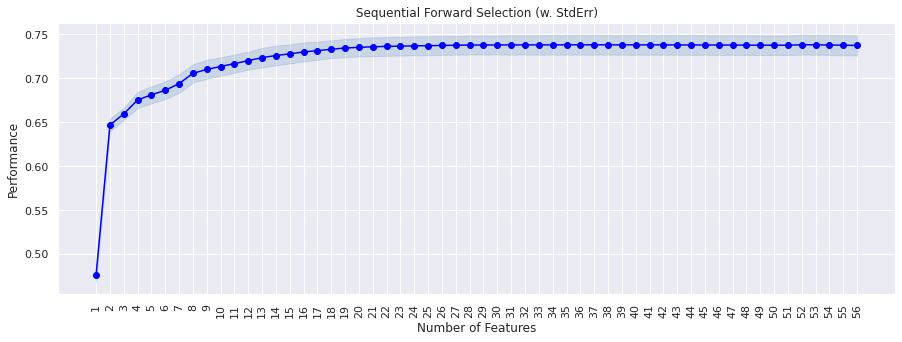

In [42]:
reg = LinearRegression()


sfs = SFS(
    reg,
    k_features=x_train.shape[1],
    forward=True,  
    floating=False,
    scoring="r2",
    n_jobs=-1,
    verbose=2,
    cv=5,
)

# Perform SFFS
sfs = sfs.fit(x_train, y_train)
fig1 = plot_sfs(sfs.get_metric_dict(), kind="std_err", figsize=(15, 5))
plt.title("Sequential Forward Selection (w. StdErr)")
plt.xticks(rotation=90)
plt.show()